Calculate Correlation Matrix

In [ ]:
data.to_csv('E:/AI engineer/Guvi/Capstone Projects/Project3/train_scaled.csv', index=False)

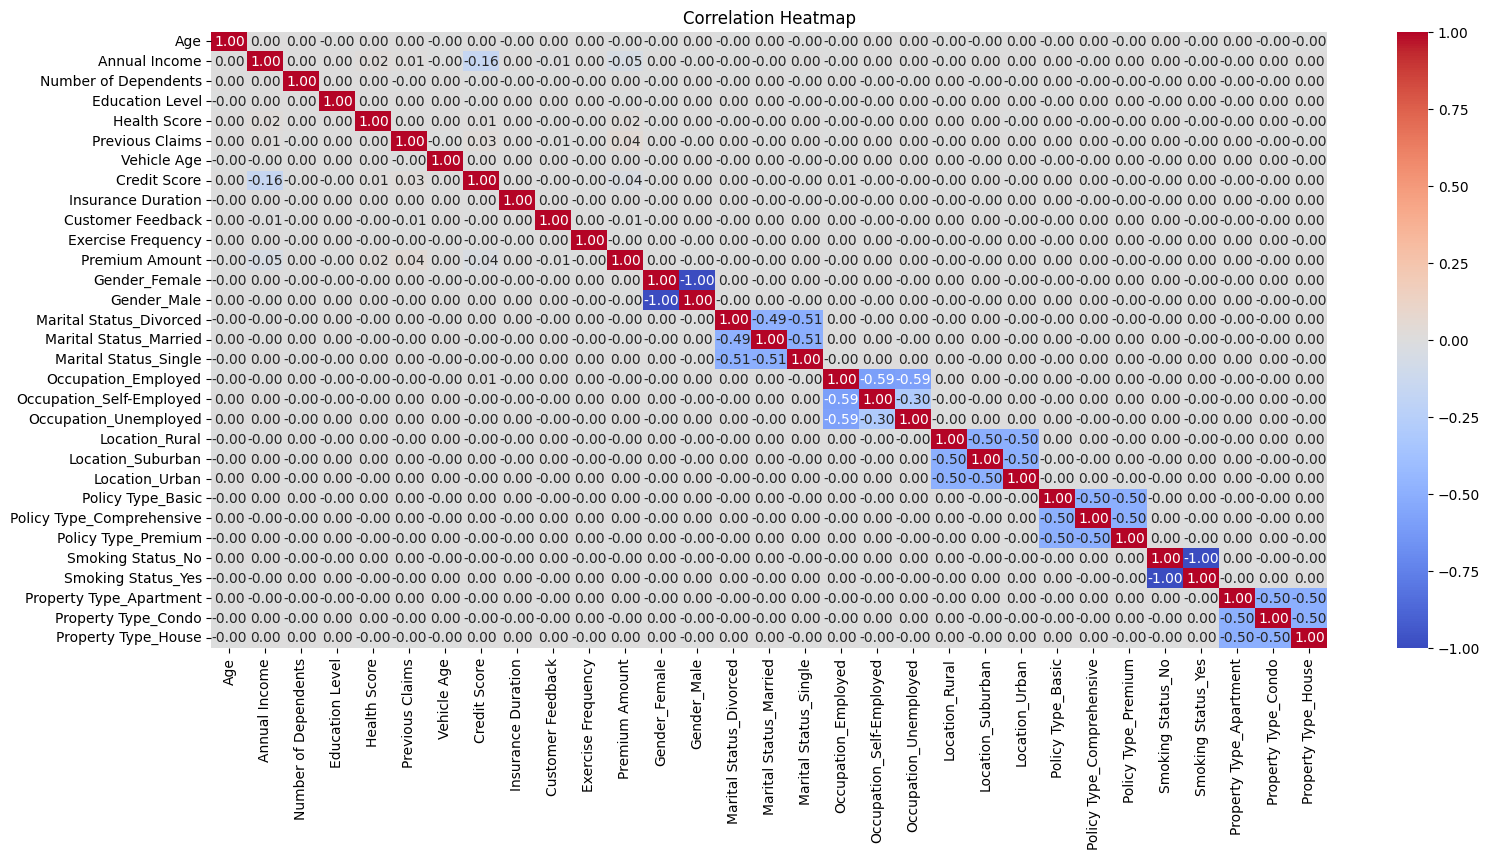

In [ ]:
# Calculate correlation matrix
corr_matrix = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Correlation with target variable
print(corr_matrix['Premium Amount'].sort_values(ascending=False))

Premium Amount               1.000000
Previous Claims              0.043048
Health Score                 0.016240
Marital Status_Single        0.004048
Occupation_Self-Employed     0.001714
Occupation_Unemployed        0.001375
Location_Urban               0.001320
Property Type_Apartment      0.001006
Policy Type_Basic            0.000800
Vehicle Age                  0.000584
Smoking Status_Yes           0.000472
Gender_Female                0.000185
Property Type_House          0.000117
Number of Dependents         0.000103
Insurance Duration           0.000072
Policy Type_Comprehensive    0.000039
Gender_Male                 -0.000185
Location_Suburban           -0.000209
Smoking Status_No           -0.000472
Policy Type_Premium         -0.000837
Education Level             -0.000850
Exercise Frequency          -0.000997
Location_Rural              -0.001108
Property Type_Condo         -0.001124
Marital Status_Married      -0.001956
Marital Status_Divorced     -0.002144
Age         

## Feature Selection

In [ ]:
# Select features with correlation above a threshold (e.g., 0.01 or -0.01)
selected_features = corr_matrix['Premium Amount'][abs(corr_matrix['Premium Amount']) > 0.01].index
data_selected = data[selected_features]
data_selected

,Annual Income,Health Score,Previous Claims,Credit Score,Premium Amount
0,-0.696886,-0.249610,1.400638,-1.567375,53.563047
1,0.225848,-0.844110,0.326401,0.714630,38.509739
2,0.012467,1.829212,0.326401,0.013020,23.811762
3,2.531313,-1.235840,0.326401,-1.602810,27.658633
4,0.476803,-0.437598,-0.747835,0.034281,44.966654
...,...,...,...,...,...
1199995,0.075012,-0.996082,-0.747835,-1.567375,36.097091
1199996,0.358656,-1.189716,-0.747835,0.027194,28.653098
1199997,0.816931,-0.915601,-0.747835,0.013020,19.261360
1199998,-0.051326,-0.592267,0.326401,-1.319331,24.413111


## Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from skopt import BayesSearchCV 


In [ ]:
# Split data
X = data.drop(columns=['Premium Amount'])
y = data['Premium Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train models
"""models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}"""

'models = {\n    "Linear Regression": LinearRegression(),\n    "Decision Tree": DecisionTreeRegressor(),\n    "XGBoost": XGBRegressor(),\n    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)\n}'

In [ ]:
# Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R² Score:", r2_score(y_test, y_pred))
    print("-" * 40)

NameError: name 'models' is not defined

In [ ]:
# Function to Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test, np.abs(y_pred)))  # Ensuring non-negative values
    
    print(f"\n{model.__class__.__name__} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSLE: {rmsle:.4f}")

## Model tuning

In [ ]:
# Bayesian Optimization for Random Forest
rf_search = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': (50, 300),  # Number of trees
        'max_depth': (3, 20),       # Depth of each tree
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 10)
    },
    n_iter=20,  # Number of iterations
    cv=3,       # Cross-validation
    scoring='neg_mean_absolute_error',
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
evaluate_model(best_rf, X_test, y_test)

In [ ]:
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Define the function to maximize
def objective(n_estimators, learning_rate, max_depth):
    model = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_absolute_error(y_test, y_pred)  # We minimize MAE, so return negative MAE

# Define parameter search space
param_bounds = {
    "n_estimators": (50, 300),
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 20),
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=param_bounds,
    random_state=42
)

optimizer.maximize(n_iter=20)  # Perform 20 iterations

# Best parameters
print(optimizer.max)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
